In [2]:
import torch
from transformers import DistilBertForMaskedLM
from transformers import DistilBertTokenizer
import matplotlib.pyplot as plt
import numpy as np

/home/pierrick/miniconda3/envs/metaphore/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model = DistilBertForMaskedLM.from_pretrained("distilbert-base-uncased")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

In [4]:
def create_maskedSentences(text):
    masked_sentences = []
    inputs = tokenizer(text, return_tensors="pt")
    n_tokens = inputs["input_ids"].shape[1]
    for i in range(1, n_tokens-1):
        s = tokenizer(text, return_tensors="pt")
        s["labels"] = s["input_ids"].detach().clone()
        t = torch.zeros(n_tokens, dtype=torch.bool)
        t[i] = True
        s["input_ids"][0,i] = 103  # MASK token
        masked_sentences.append({"inputs": s, "mask": t, "id_masked": i})
    return masked_sentences

def print_inputs(inputs):
    return " ".join(list(map(tokenizer.convert_ids_to_tokens, inputs["input_ids"]))[0])

def parse_sentences(sentences):
    """_summary_

    Args:
        sentences (list): list of dict containing keys : 
            - 'inputs' : transformers.tokenization_utils_base.BatchEncoding with 'input_ids', 'attention_mask' and 'labels'. One of the tokens in input_ids is a MASK token (103)
            - 'id_masked' : index of the masked word
    """
    for sentence in sentences:
        inputs = sentence["inputs"]
        loss, logits = model(**inputs).values()
        score_surprise = ((logits[:, sentence["id_masked"], :].argsort(descending=True) == sentence["inputs"]["labels"][0,sentence["id_masked"]]).flatten()).nonzero()[0,0].item()
        sentence["score_surprise"] = score_surprise
        
def plot_barSurprise(sentences):
    """_summary_

    Args:
        sentences (list): list of dict containing keys : 
            - 'inputs' : transformers.tokenization_utils_base.BatchEncoding with 'input_ids', 'attention_mask' and 'labels'. One of the tokens in input_ids is a MASK token (103)
            - 'id_masked' : index of the masked word
            - 'score_surprise' (float): high value = big surprise
    """
    scores = [x["score_surprise"] for x in sentences]
    words = list(map(tokenizer.convert_ids_to_tokens, sentences[0]["inputs"]["labels"]))[0][1:-1]
    plt.bar(words, scores)
    plt.gca().margins(x=0)
    plt.gcf().canvas.draw()
    tl = plt.gca().get_xticklabels()
    maxsize = max(t.get_window_extent().width for t in tl)
    m = 1 # inch margin
    s = maxsize/plt.gcf().dpi*len(words)+2*m
    margin = m/plt.gcf().get_size_inches()[0]

    plt.gcf().subplots_adjust(left=margin, right=1.-margin)
    plt.gcf().set_size_inches(s, plt.gcf().get_size_inches()[1])
    
def highlight_text(sentences, lamb = 0.01):
    """_summary_

    Args:
        sentences (_type_): _description_
        lamb (float, optional): _description_. Defaults to 0.01.
    """
    scores = [x["score_surprise"] for x in sentences]
    words = list(map(tokenizer.convert_ids_to_tokens, sentences[0]["inputs"]["labels"]))[0][1:-1]
    fig, ax = plt.subplots()
    fig.set_size_inches((10,6))
    plt.axis('off')
    offset_y = 0.1
    offset_x = 0.01
    for i in range(len(words)):
        t = plt.text(offset_x + (i%10)/10,1-offset_y-(i//10)/10,words[i])
        t.set_bbox(dict(facecolor='red', alpha=1-np.exp(-scores[i]*lamb)))
        plt.text(offset_x + 0.01 + (i%10)/10,1-offset_y-0.045-(i//10)/10,scores[i], fontdict={"fontsize":7})

In [61]:
# text = "Peter is brave and never gives up. He has the heart of a lion."
# text = "Since I started this new job I am always looking forward to meet new people. I am open to all opportunities. It is like I am always searching for my next prey"
text = ""
masked_sentences = create_maskedSentences(text)
masked_sentences[:2]

[{'inputs': {'input_ids': tensor([[ 101,  103, 2017, 2031, 2445, 1037, 9121, 2000, 2115, 3899, 1010, 2202,
           2009, 4237, 1998, 4550, 2009, 1012,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'labels': tensor([[ 101, 2320, 2017, 2031, 2445, 1037, 9121, 2000, 2115, 3899, 1010, 2202,
           2009, 4237, 1998, 4550, 2009, 1012,  102]])},
  'mask': tensor([False,  True, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False]),
  'id_masked': 1},
 {'inputs': {'input_ids': tensor([[ 101, 2320,  103, 2031, 2445, 1037, 9121, 2000, 2115, 3899, 1010, 2202,
           2009, 4237, 1998, 4550, 2009, 1012,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'labels': tensor([[ 101, 2320, 2017, 2031, 2445, 1037, 9121, 2000, 2115, 3899, 1010, 2202,
           2009, 4237, 1998, 4550, 2009, 1012,  102]])},
  'mask': tensor([Fals

In [62]:
parse_sentences(masked_sentences)
masked_sentences[:2]

[{'inputs': {'input_ids': tensor([[ 101,  103, 2017, 2031, 2445, 1037, 9121, 2000, 2115, 3899, 1010, 2202,
           2009, 4237, 1998, 4550, 2009, 1012,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'labels': tensor([[ 101, 2320, 2017, 2031, 2445, 1037, 9121, 2000, 2115, 3899, 1010, 2202,
           2009, 4237, 1998, 4550, 2009, 1012,  102]])},
  'mask': tensor([False,  True, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False]),
  'id_masked': 1,
  'score_surprise': 2},
 {'inputs': {'input_ids': tensor([[ 101, 2320,  103, 2031, 2445, 1037, 9121, 2000, 2115, 3899, 1010, 2202,
           2009, 4237, 1998, 4550, 2009, 1012,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'labels': tensor([[ 101, 2320, 2017, 2031, 2445, 1037, 9121, 2000, 2115, 3899, 1010, 2202,
           2009, 4237, 1998, 4550, 2009, 1012,  102]])},

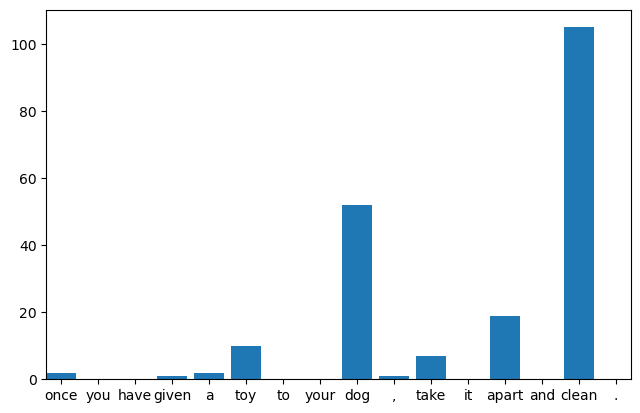

In [63]:
plot_barSurprise(masked_sentences)

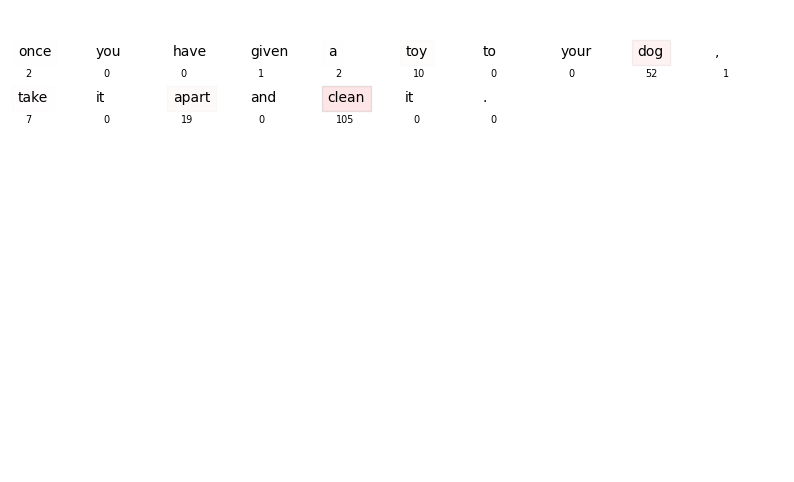

In [64]:
highlight_text(masked_sentences, lamb=0.001)

# //

# <>